# Computer Simulation: Output Analysis

**In the lab you will learn how to :**

* how to perform multiple replications of a simulation model implemented in `simpy`.
* how to estimate and use warm-up period of a non-terminating simulation model.
* how to select the number of replications to run of a single scenario.
* how to compare multiple competing scenarios

-----

# Imports

Please use the provided `hds_stoch` environment for this work.  

In [1]:
#!pip install simpy~

import simpy
simpy.__version__

'4.0.1'

# Standard imports

In [2]:
import numpy as np
import pandas as pd
import itertools
import math
import matplotlib.pyplot as plt
from scipy.stats import t

# Import model classes

In [3]:
from hds_simpy.models.UrgentCareCallCentre import (UrgentCareCallCentre, 
                                                   Auditor,
                                                   Scenario, run_results)

# Test single run of the model

In [4]:
FIRST_OBS = 30
OBS_INTERVAL = 30

env = simpy.Environment()
args = Scenario()


#create an instance of the model
model = UrgentCareCallCentre(env, args)

#create model auditor
auditor = Auditor(env, first_obs=FIRST_OBS, interval=OBS_INTERVAL)
auditor.add_resource_to_audit(args.operators, 'ops')
auditor.add_resource_to_audit(args.nurses, 'nurse')

#run the model
model.run()

print(f'end of run. simulation clock time = {env.now}')
print('\nSingle run results\n-------------------')
results_summary = run_results(model, auditor)
print(results_summary)

end of run. simulation clock time = 1440

Single run results
-------------------
                    estimate
mean_queue_ops      5.340426
mean_queue_nurse    2.765957
mean_system_ops    17.872340
mean_system_nurse  12.829787
mean_nurse_wait     4.160545
mean_wait           3.264443
nurse_util          0.917929
ops_util            0.962040


---
# Exercise 1: Performing a single run of the model.

This exercise is a reminder of how to perform a single run of the model and how to organise your code in functions.  You will see the real benefit of using functions in exercise 2.  You will analyse the base scenario using the default parameters.

## Using classes and functions to organise results collection and experimentation.

**As a reminder**, in practice, it is a good idea to use classes functions to organise the running of your model.

### `model_performance_measures()`
The function `model_performance_measures` accepts an instance of `MinorInjuryUnit` as a parameter. It then assumes this model has been run and calculates the `mean_time_in_system` and other performance measures.  For now ignore the `warmup` parameter.  You will learn how to use it in the next section.


### `single_model_run()`

The function `single_model_run` accepts a parameter `scenario` which contains all of the parameters you wish to use for the run.  It also accepts a parameters called `results_collection_period` that refers to the length of time the model will be run.  Again you don't need to do anything with `warmup` (default=0), but note that the `results_collection_period` + `warmup` = your models **run length**.  When the model run is complete the function calls `model_performance_measures` and returns the desired performance measures. 


**Task**
* Read and check you understand the functions and script provided.
* Run the code below to create the functions and then run the script.  This will output the results of a single run.

In [5]:
def single_model_run(scenario, results_collection_period, warm_up=0, 
                     include_audit=False, audit_interval=60,
                     random_no_set=1):
    '''
    Perform a single run of the model and return the results
    
    Parameters:
    -----------
    
    scenario: Scenario object
        The scenario/paramaters to run
        
    results_collection_period: int
        The length of the simulation run that collects results
        
    include_audit: bool, optional (default=False)
        Audit the model during its run
        
    audit_interval: int, optional (default=60)
        during between audits as the model runs.
        
    Returns:
    --------
        Tuple:
        (mean_time_in_system, mean_time_to_nurse, mean_time_to_triage,
         four_hours)
    '''
    
    FIRST_OBS = 30
    OBS_INTERVAL = 30

    #simulation environment
    env = simpy.Environment()
        
    #set random number set
    scenario.set_random_no_set(random_no_set)

    #create an instance of the model
    model = UrgentCareCallCentre(env, scenario)

    #create model auditor
    auditor = Auditor(env, first_obs=audit_interval, 
                           interval=audit_interval)
    auditor.add_resource_to_audit(scenario.operators, 'ops')
    auditor.add_resource_to_audit(scenario.nurses, 'nurse')

    #run the model
    model.run(results_collection_period, warm_up)
    
    results_summary = run_results(model, auditor)
    
    return results_summary.T

### Script to run the scenarios.

In [6]:
RUN_LENGTH = 1440
TRACE = False

#default scenario
default_args = Scenario()
default_args.set_random_no_set(1)

#loop through each scenario and store results in a dict
print('Running simulation ... \n\n')
results = {}
results['base'] = single_model_run(default_args, RUN_LENGTH)
print('simulation complete.\n\n')

#convert results to dataframe and printout
results['base'].round(2)

Running simulation ... 


simulation complete.




,mean_queue_ops,mean_queue_nurse,mean_system_ops,mean_system_nurse,mean_nurse_wait,mean_wait,nurse_util,ops_util
estimate,4.91,3.22,17.43,13.17,4.16,3.26,0.92,0.96


# Exercise 2: Performing multiple replications of a single scenario

Here is where the benefit of using functions to organise your experimentation really pays off!  To perform multiple replications we just need to call `single_model_run` multiple times in a loop.

**Task**:

* Create a function called `multiple_replications`.  The function should accept the following parameters:
   * scenario: `Scenario` - Parameters/arguments to configurethe model
   * runlength: `int` - number of minutes to run the model in simulated time
   * n_reps: `int`, optional (default=5) - Number of independent replications to run.
* The purpose of `multiple_replications` is to conduct `n_reps` independent replications of the MIU model.
* The function should return a list of results.
* After coding the function make use of the script provided to run 5 independent replications of the MIU model and output the value of each performance measure in each replication.

**Questions**
* What is the mean performance of the model with 5 replications?

**Hints**
* Try calling `single_model_run` in a for loop
* Alternatively you could make use of a list comprehension.



In [7]:
#your code here...


In [8]:
#example solution
def multiple_replications(scenario, results_collection_period, warm_up=0,
                          n_reps=5):
    '''
    Perform multiple replications of the MIU model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    runlength: int
        number of minutes to run the model in simulated time
        
    n_reps: int, optional (default=5)
        Number of independent replications to run.
        
    Returns:
    --------
    List
    '''
    results = [single_model_run(scenario, results_collection_period, warm_up,
                                random_no_set=rep) 
               for rep in range(n_reps)]
    return results
        

In [9]:
RUN_LENGTH = 1440
TRACE = False
N_REPS = 5

#default scenario
default_args = Scenario()

#loop through each scenario and store results in a dict
print('Running simulation ... \n\n')
results = {}
results['base'] = multiple_replications(default_args, RUN_LENGTH, n_reps=5)

#convert results to dataframe and printout
base_results = pd.concat(results['base'])
base_results.index = np.arange(1, len(base_results)+1)
base_results.index.name = 'rep'
base_results.round(3)

Running simulation ... 




,mean_queue_ops,mean_queue_nurse,mean_system_ops,mean_system_nurse,mean_nurse_wait,mean_wait,nurse_util,ops_util
rep,,,,,,,,
1,9.565,2.957,22.304,13.652,4.060,5.127,0.949,0.967
2,4.913,3.217,17.435,13.174,4.161,3.264,0.918,0.962
3,6.957,4.696,19.391,14.739,6.484,3.925,0.918,0.945
4,4.783,1.130,17.043,10.522,2.652,2.771,0.891,0.934
5,4.304,1.652,16.522,11.391,2.332,2.250,0.894,0.936


In [10]:
#mean results
base_results.mean()

mean_queue_ops        6.104348
mean_queue_nurse      2.730435
mean_system_ops      18.539130
mean_system_nurse    12.695652
mean_nurse_wait       3.937800
mean_wait             3.467253
nurse_util            0.913974
ops_util              0.948982
dtype: float64

# Exercise 3: Estimating and including a the warm-up period in the model.

Our MIU model is a non-terminating simulation.  To estimate a warm-up period of the model we will use the **time series inspection approach**.  We will run 5 replications of the model and plot the mean performance measures over time.  We the choose a warm-up that allows the model to approximately settle to a steady state.

**Task:**
* Using the functions you have created 


In [11]:
def warmup_metrics(model):
    #waiting time = sum(waiting times) / no. patients
    mean_waiting_time = np.array([patient.waiting_time 
                                  for patient in model.patients]).mean()


    #operator utilisation = sum(call durations) / (run length X no. operators)
    util = np.array([patient.call_duration 
                     for patient in model.patients]).sum() / \
                     (model.env.now * model.args.n_operators)
    
    #nurse waiting time 
    nurse_waiting_time = np.array([patient.waiting_time_nurse 
                                  for patient in model.patients
                                  if patient.callback]).mean()
   
    
    #nurse utilisation = sum(call durations) / (run length X no. operators)
    nurse_util = np.array([patient.nurse_call_duration 
                          for patient in model.patients if patient.callback]).sum() / \
                          (model.env.now * model.args.n_nurses)
    
    return mean_waiting_time, util, nurse_waiting_time, nurse_util


In [12]:
class WarmupAuditor():
    '''
    Warmup Auditor for the model.
    
    Stores the cumulative means for:
    1. operator waiting time
    2. nurse waiting time
    3. operator utilisation
    4. nurse utilitsation.
    
    '''
    def __init__(self, env, model, interval):
        self.env = env
        self.model = model
        self.interval = interval
        self.wait_for_operator = []
        self.wait_for_nurse = []
        self.operator_util = []
        self.nurse_util = []

    def audit_model(self):
        for i in itertools.count():
            yield self.env.timeout(self.interval)

            #Performance metrics

            #get the performance metrics at this time.
            mean_waiting_time, util, nurse_waiting_time, nurse_util \
                = warmup_metrics(self.model)
            
            #store the metrics
            self.wait_for_operator.append(mean_waiting_time)
            self.wait_for_nurse.append(nurse_waiting_time)
            self.operator_util.append(util)
            self.nurse_util.append(nurse_util)

        return results

In [13]:
def warm_up_single_run(scenario, results_collection_period, 
                       audit_interval=240, random_no_set=1):
    '''
    Perform a single run of the model as part of the warm-up
    analysis.
    
    Parameters:
    -----------
    
    scenario: Scenario object
        The scenario/paramaters to run
        
    results_collection_period: int
        The length of the simulation run that collects results
               
    audit_interval: int, optional (default=60)
        during between audits as the model runs.
        
    Returns:
    --------
        Tuple:
        (mean_time_in_system, mean_time_to_nurse, mean_time_to_triage,
         four_hours)
    '''
    
    #simulation environment
    env = simpy.Environment()
        
    #set random number set
    scenario.set_random_no_set(random_no_set)

    #create an instance of the model
    model = UrgentCareCallCentre(env, scenario)

    #create warm-up model auditor
    auditor = WarmupAuditor(env, model, audit_interval)
    
    #set up data collection for warmup variables.
    env.process(auditor.audit_model())

    #run the model
    model.run(results_collection_period)
        
    return auditor

In [14]:
from joblib import Parallel, delayed

In [37]:
#example solution
def warmup_analysis(scenario, results_collection_period, n_reps=5, n_jobs=-1):
    '''
    Perform multiple replications of the MIU model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    results_collection_period: int
        number of minutes to run the model in simulated time
        
    n_reps: int, optional (default=5)
        Number of independent replications to run.
        
    Returns:
    --------
    List of WarmupAuditors
    '''
    results = [warm_up_single_run(scenario, results_collection_period,
                                  random_no_set=rep) 
               for rep in range(n_reps)]
    
    
    return results
        

In [38]:
%%time
#script
#note this will take 10-20 seconds to run...

RUN_LENGTH = 1440 * 20
TRACE = False
N_REPS = 5

#load scenarios using your function
default_args = Scenario()

#create simpy environment
env = simpy.Environment()

print('Running multiple replications...')
#perform multiple replications
results = warmup_analysis(default_args, RUN_LENGTH, n_reps=N_REPS)

print('Complete')

Running multiple replications...
Complete
CPU times: user 16.7 s, sys: 4 ms, total: 16.7 s
Wall time: 16.7 s


In [39]:
metrics = {'operator_wait':[],
           'nurse_wait':[],
           'operator_util':[],
           'nurse_util':[]}

#preprocess results of each replication
for audit in results:
    metrics['operator_wait'].append(audit.wait_for_operator)
    metrics['nurse_wait'].append(audit.wait_for_nurse)
    metrics['operator_util'].append(audit.operator_util)
    metrics['nurse_util'].append(audit.nurse_util)

Text(0, 0.5, 'nurse_util')

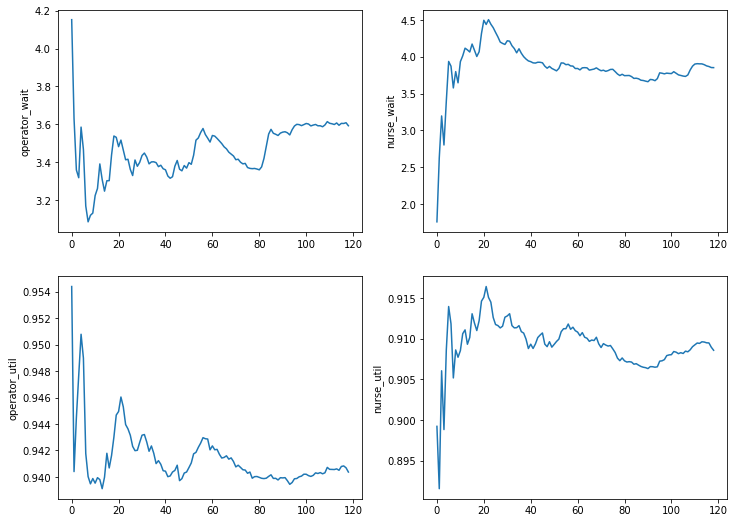

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(12,9))
ax[0][0].plot(np.array(metrics['operator_wait']).mean(axis=0))
ax[0][1].plot(np.array(metrics['nurse_wait']).mean(axis=0))
ax[1][0].plot(np.array(metrics['operator_util']).mean(axis=0))
ax[1][1].plot(np.array(metrics['nurse_util']).mean(axis=0))

ax[0][0].set_ylabel('operator_wait')
ax[0][1].set_ylabel('nurse_wait')
ax[1][0].set_ylabel('operator_util')
ax[1][1].set_ylabel('nurse_util')

# Rerunning the model with warm up time 
## (deleting the initial transient)

In [19]:
def model_performance_measures(model, warmup=0):
    #Performance metrics

    #1. mean time in system
    mean_time_in_system = np.array([patient.time_in_system 
                                    for patient in model.patients
                                    if patient.arrival_time > warmup]).mean()


    #2. mean time to first treatment
    mean_time_to_nurse = np.array([patient.time_to_nurse 
                                   for patient in model.patients
                                   if patient.arrival_time > warmup]).mean()

    #3. mean time to triage
    mean_time_to_triage = np.array([patient.time_to_triage 
                                   for patient in model.patients
                                   if patient.arrival_time > warmup]).mean()


    #4. four hour target
    four_hours = np.array([patient.four_hour_target 
                           for patient in 
                           model.patients if patient.arrival_time > warmup]
                          ).sum() / len(model.patients)
        
    #return results.
    return (mean_time_in_system, mean_time_to_nurse, mean_time_to_triage,
            four_hours)

In [20]:
def results_summary(results):
    
    #convert results to dataframe and printout
    results = pd.DataFrame(results)
    results.columns = ['Time in System', 'Time to Nurse', 'Time to Triage', 
                       '4 Hr performance']

    return results.mean()

In [21]:
#script

INCLUDE_AUDIT = False
AUDIT_INTERVAL = 90
WARM_UP = 200 * AUDIT_INTERVAL
RESULTS_COLLECTION = 1440
RUN_LENGTH = WARM_UP + RESULTS_COLLECTION
TRACE = False

N_REPS = 100

#load scenarios using your function
default_args = Scenario()

#create simpy environment
env = simpy.Environment()

print('Running multiple replications...')
#perform multiple replications
results = multiple_replications(default_args, RUN_LENGTH, n_reps=N_REPS,
                                include_audit=INCLUDE_AUDIT)

print('Complete')

results_summary(results)

Running multiple replications...


TypeError: multiple_replications() got an unexpected keyword argument 'include_audit'

# Selecting the number of replications to run.

You will use the **confidence interval method** to select the number replications to run in order to get a good estimate the models mean performance.  The narrower the confidence interval the more precise our estimate of the mean. In general, the more replications you run the narrower the confidence interval. The method requires you to set a predefined width of the confidence interval.  In this course, we will make the somewhat arbitrary decision to opt for an interval that is 5% either side of the mean.

A confidence interval is calculated as:

$$ CI = \overline{X} \pm t_{n-1, \alpha/2} \dfrac{S}{\sqrt{n}}$$


where: 

* $\overline{X}$ = mean of the output data from the replications
* $S$ = standard deviation of the output data from the replications
* $n$ = the number of replications
* $t_{n-1, \alpha/2}$ = value from the *t*-distribution with $n-1$ degrees of freedomand a significance level of $\alpha/2$

## Implementation in python

The function `confidence_interval_method` is provided for you.  

In [ ]:
def confidence_interval_method(replications, alpha=0.05, desired_precision=0.05, 
                               min_rep=5, decimal_place=2):
    '''
    The confidence interval method for selecting the number of replications
    to run in a simulation.
    
    Finds the smallest number of replications where the width of the confidence
    interval is less than the desired_precision.  
    
    Returns both the number of replications and the full results dataframe.
    
    Parameters:
    ----------
    replications: arraylike
        Array (e.g. np.ndarray or list) of replications of a performance metric
        
    alpha: float, optional (default=0.05)
        procedure constructs a 100(1-alpha) confidence interval for the 
        cumulative mean.
        
    desired_precision: float, optional (default=0.05)
        Desired mean deviation from confidence interval.
        
    min_rep: int, optional (default=5)
        set to a integer > 0 and ignore all of the replications prior to it 
        when selecting the number of replications to run to achieve the desired
        precision.  Useful when the number of replications returned does not
        provide a stable precision below target.
        
    decimal_places: int, optional (default=2)
        sets the number of decimal places of the returned dataframe containing
        the results
    
    Returns:
    --------
        tuple: int, pd.DataFrame
    
    '''

    n = len(replications)
    cumulative_mean = [replications[0]]
    running_var = [0.0]
    for i in range(1, n):
        cumulative_mean.append(cumulative_mean[i-1] + \
                       (replications[i] - cumulative_mean[i-1] ) / (i+1))
        
        #running biased variance
        running_var.append(running_var[i-1] + (replications[i] 
                                               - cumulative_mean[i-1]) \
                            * (replications[i] - cumulative_mean[i]))
        
    #unbiased std dev = running_var / (n - 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        running_std = np.sqrt(running_var / np.arange(n))
    
    #half width of interval
    dof = len(replications) - 1
    t_value = t.ppf(1 - (alpha / 2),  dof)    
    with np.errstate(divide='ignore', invalid='ignore'):
        std_error = running_std / np.sqrt(np.arange(1, n+1))
        
    half_width = t_value * std_error
        
    #upper and lower confidence interval
    upper = cumulative_mean + half_width
    lower = cumulative_mean - half_width
    
    #Mean deviation
    with np.errstate(divide='ignore', invalid='ignore'):
        deviation = (half_width / cumulative_mean) * 100
    
    #commbine results into a single dataframe
    results = pd.DataFrame([replications, cumulative_mean, 
                            running_std, lower, upper, deviation]).T
    results.columns = ['Mean', 'Cumulative Mean', 'Standard Deviation', 
                       'Lower Interval', 'Upper Interval', '% deviation']
    results.index = np.arange(1, n+1)
    results.index.name = 'replications'
    
    #get the smallest no. of reps where deviation is less than precision target
    try:
        n_reps = results.iloc[min_rep:].loc[results['% deviation'] 
                             <= desired_precision*100].iloc[0].name
    except:
        #no replications with desired precision
        message = 'WARNING: the replications do not reach desired precision'
        warnings.warn(message)
        n_reps = -1 

    
    return n_reps, results.round(2)
        

# Confidence interval method example: `time_in_system`

Let's look at an example of using it with the performance measure `time_in_system`

## Step 1: preprocess the replications
The function only works for a single performance measure at a time.  Before we use it we need to get our results into seperate
lists or arrays.  (note how you do this will vary depending on how your model collects and processes results).

In [ ]:
#let's store the results in a dict where each key represents a performance 
#metric
replications = {}

replications['time_in_system'] = [results[i][0] for i in range(len(results))]
replications['time_to_nurse'] = [results[i][1] for i in range(len(results))]   
replications['time_to_triage'] = [results[i][2] for i in range(len(results))]   
replications['four_hours'] = [results[i][3] for i in range(len(results))]   

## Step 2: pass the replications to the method

The function `confidence_interval_method` returns a tuple `(int, pandas.DataFrame)`.  The first element is the minimum number of replications required to achieve the precision (desired width of the interval).  The second, element is all of the data including the confidence interval.

In [ ]:
#run the method on the time_in_system replications
n_reps, conf_ints = confidence_interval_method(replications['time_in_system'])

#print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

#peek at table of results
conf_ints.head()

## Step 3: Plot the results

It is useful to look at the results visually to check if the confidence intervals converge or if the expand again later on.

The function `plot_confidence_interval_method` has been provided to help.

Run the code below to produce the plot.  Do you think it looks stable?


In [ ]:
def plot_confidence_interval_method(n_reps, conf_ints, metric_name, 
                                    figsize=(12,4)):
    '''
    Plot the confidence intervals and cumulative mean
    
    Parameters:
    ----------
    n_reps: int
        minimum number of reps selected
        
    conf_ints: pandas.DataFrame
       results of the `confidence_interval_method` function
       
    metric_name: str
        Name of the performance measure
        
    figsize: tuple, optional (default=(12,4))
        The size of the plot
        
    Returns:
    -------
        matplotlib.pyplot.axis
    '''
    #plot cumulative mean + lower/upper intervals
    ax = conf_ints[['Cumulative Mean', 'Lower Interval', 
                         'Upper Interval']].plot(figsize=figsize)
    #add the 
    ax.axvline(x=n_reps, ls='--', color='red')
    
    ax.set_ylabel(f'cumulative mean: {metric_name}')
    
    return ax

In [ ]:
#plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='time_in_system')

Another good idea is to check the % deviation 10-20 replications ahead to check quantitatively that the 5% precision is maintained.

In [ ]:
#quick check if the % deviation remains below 5% for the next 10 reps?
conf_ints.iloc[n_reps:n_reps+1]